In [1]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
from ast import literal_eval
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import re

In [3]:
def wordclean(w):
    return re.sub(r'[^\w]', ' ', w.lower()).replace(" ", "")

In [4]:
videos_df = pd.read_csv("outputs/videoInfo.csv", converters = {"tags": literal_eval})
videos_df.dtypes

videoId                object
channelTitle           object
title                  object
description            object
tags                   object
publishedAt            object
duration              float64
definition             object
caption                  bool
viewCount             float64
likeCount             float64
favoriteCount         float64
commentCount          float64
publishedAtWeekday     object
publishedAtDay         object
publishedAtHour         int64
dtype: object

In [5]:
selected_vars = [
    "title",
    "description",
    "tags",
    "channelTitle",
    "publishedAtDay",
    "publishedAtWeekday",
    "publishedAtHour"
    ]

videos_df = videos_df[selected_vars]
videos_df["shorts"] = videos_df["title"].map(lambda x: 1 if "#shorts" in x else 0)

videos_df.head()

,title,description,tags,channelTitle,publishedAtDay,publishedAtWeekday,publishedAtHour,shorts
0,The Biggest Market Crash Of Our Generation Is ...,Go to http://public.com/graham and use code GR...,"[investing, investing for beginners, investing...",Graham Stephan,2022-07-11,Monday,22,0
1,The Housing Market Bubble Just Popped,Lets talk about the current state of the housi...,"[investing, investing for beginners, investing...",Graham Stephan,2022-07-08,Friday,22,0
2,An URGENT Warning For ALL Crypto Investors,Thanks to Mine for Sponsoring: Find out which ...,"[investing, investing for beginners, investing...",Graham Stephan,2022-07-06,Wednesday,21,0
3,The Mother Of All Crashes Is Coming | Michael ...,"GET UP TO $100 OF FREE CRYPTO: Trade Bitcoin, ...","[investing, investing for beginners, investing...",Graham Stephan,2022-07-01,Friday,20,0
4,The Car Market Bubble Just Popped,Enter at https://www.omaze.com/stephan for you...,"[investing, investing for beginners, investing...",Graham Stephan,2022-06-29,Wednesday,21,0


In [6]:
tags_list_tmp = []
tags_list = []
for row in videos_df.tags.values:
    tags_list_tmp = tags_list_tmp + row
tags_list_tmp = [ph.split(" ") for ph in tags_list_tmp]
for ll in tags_list_tmp:
    tags_list = tags_list + ll
tags_list = [wordclean(w) for w in tags_list]

## WordCloud

In [7]:
stop_words = set(stopwords.words("english"))

### WordCloud Tags

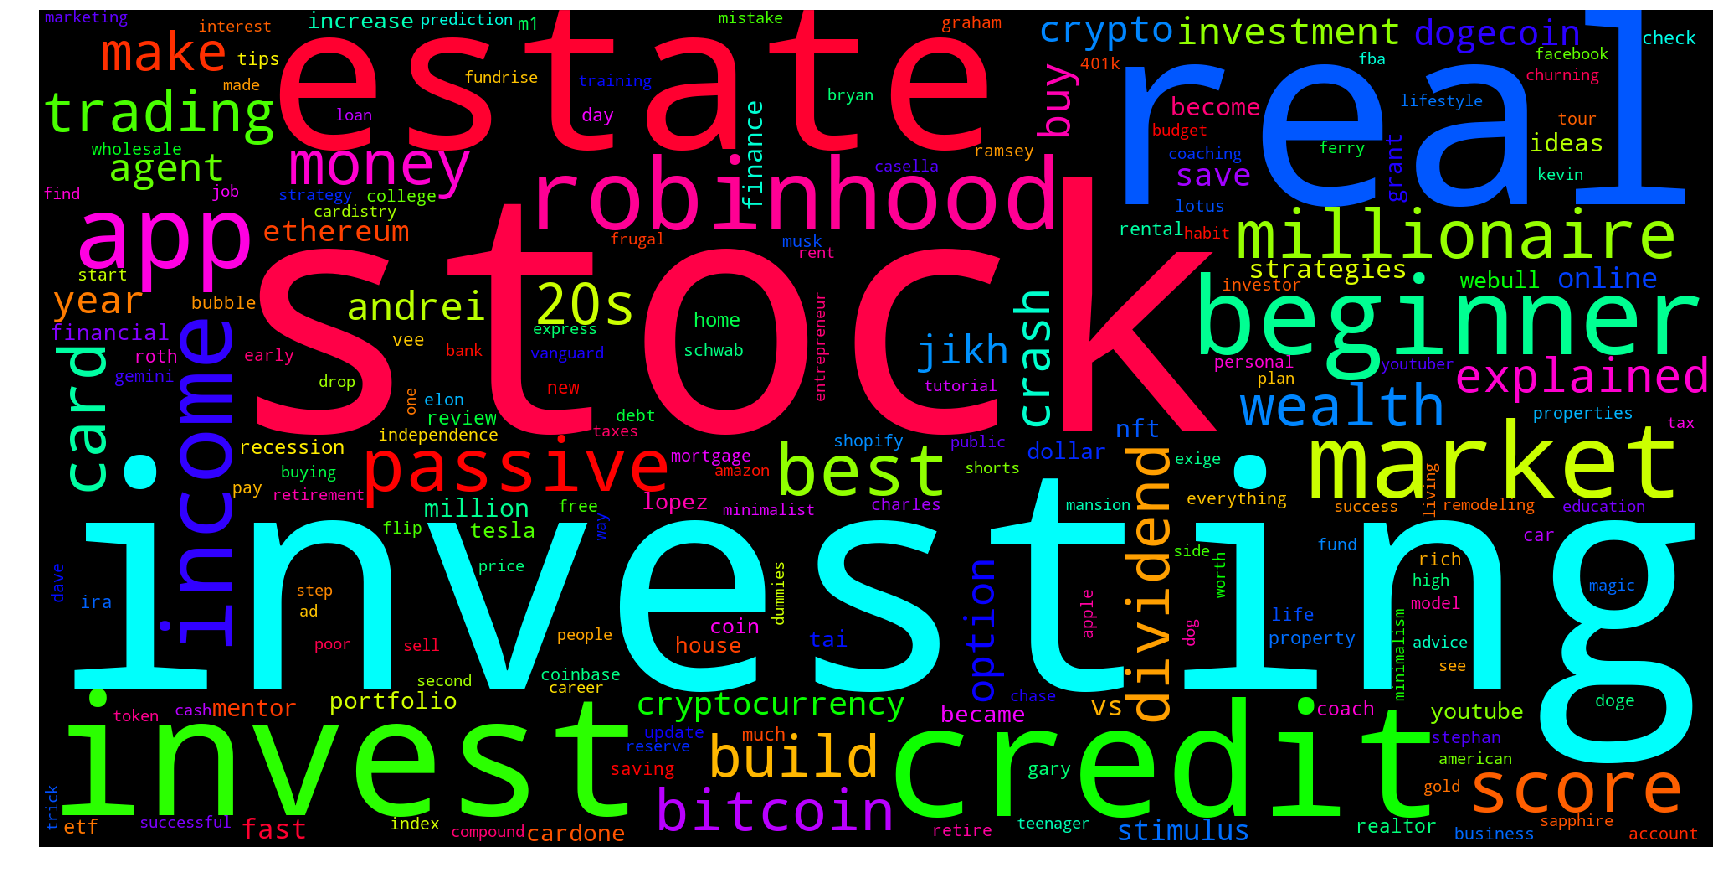

In [8]:
tags_together = ",".join([w for w in tags_list if w not in stop_words])

def plot_cloud(wordcloud):
    plt.figure(figsize=(30,20))
    plt.imshow(wordcloud)
    plt.axis("off");
    
wordcloud = WordCloud(width = 2000, height = 1000, random_state = 0, background_color = "black",
                     colormap = "hsv", collocations = False).generate(tags_together)

plot_cloud(wordcloud)

### WordCount Tags Dataframe

In [9]:
wordCountTags_df = pd.DataFrame(np.transpose(np.unique(
    [w for w in tags_list if w not in stop_words],
    return_counts = True)), columns = ["word", "count"])
wordCountTags_df["count"] = wordCountTags_df["count"].apply(pd.to_numeric)
wordCountTags_df.sort_values("count", ascending = False, inplace = True)

print(wordCountTags_df.shape)
display(wordCountTags_df.head(10))

(1627, 2)


,word,count
758,investing,4149
1195,real,3374
483,estate,3369
1402,stock,2713
756,invest,2653
359,credit,2331
185,beginners,1829
901,market,1717
1403,stocks,1582
132,app,1573


### WordCloud Titles

In [10]:
title_list = [t.split(" ") for t in videos_df.title.values]
from_title_dict = set()
for ll in title_list:
    from_title_dict = from_title_dict.union(set(ll))
from_title_list = list(from_title_dict)
from_title_list = [wordclean(w) for w in from_title_list if w != ""]

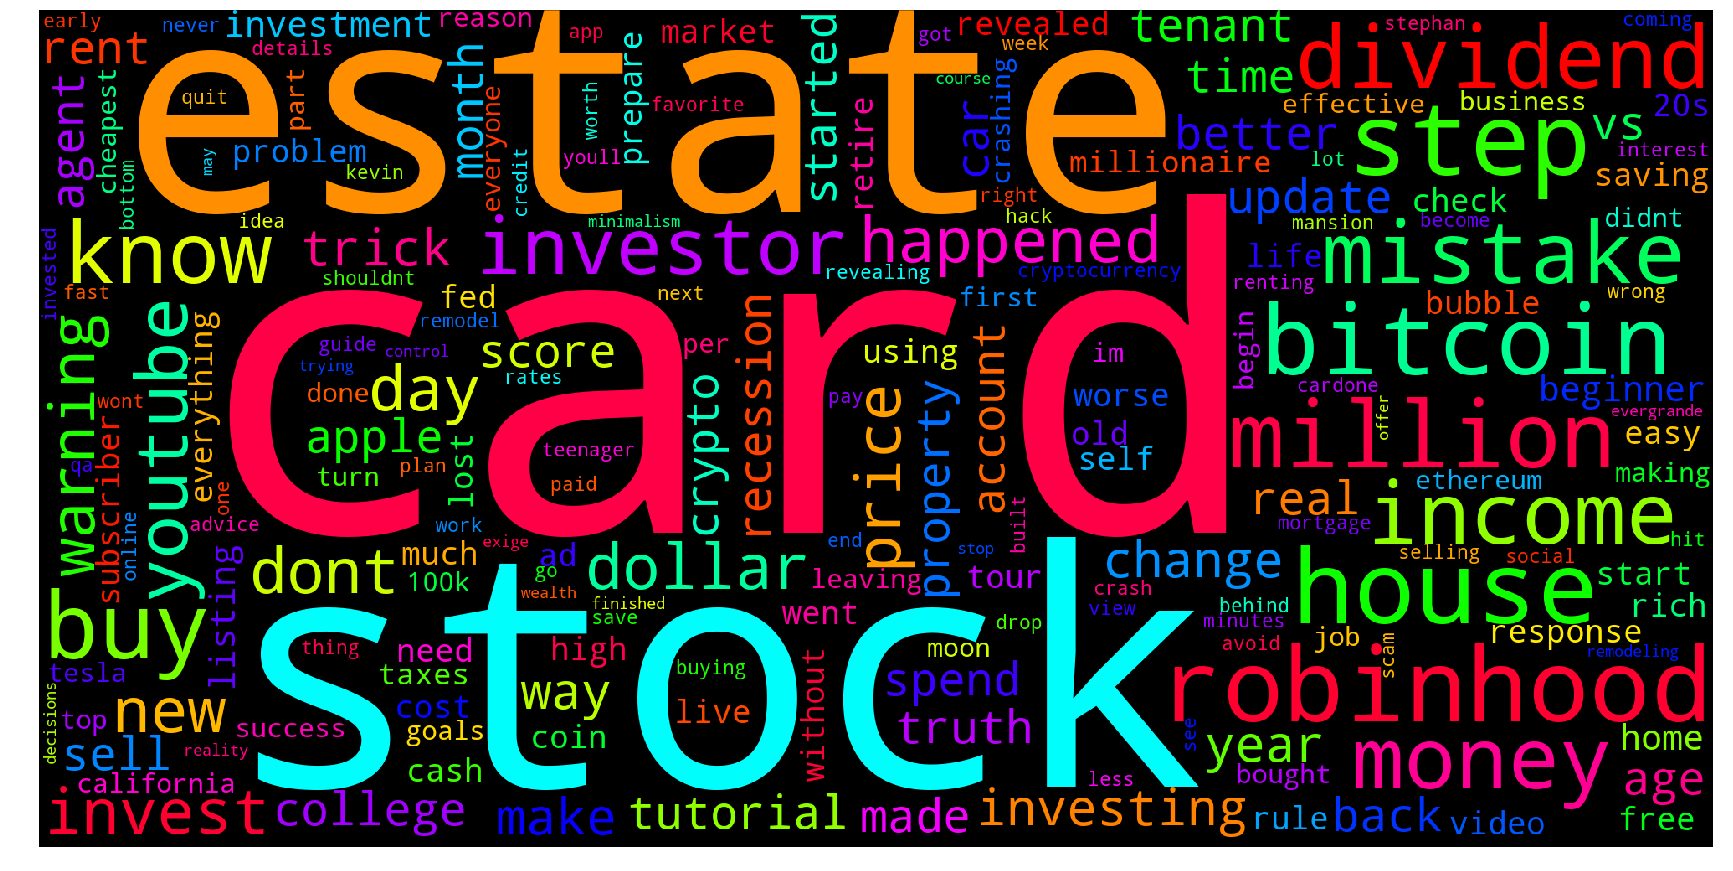

In [11]:
from_title_together = ",".join([w for w in from_title_list if w not in stop_words])
    
wordcloud = WordCloud(width = 2000, height = 1000, random_state = 0, background_color = "black",
                     colormap = "hsv", collocations = False).generate(from_title_together)

plot_cloud(wordcloud)

### WordCount Title Dataframe

In [12]:
wordCountTitle_df = pd.DataFrame(np.transpose(np.unique(
    [w for w in from_title_list if w not in stop_words],
    return_counts = True)), columns = ["word", "count"])
wordCountTitle_df["count"] = wordCountTitle_df["count"].apply(pd.to_numeric)
wordCountTitle_df.sort_values("count", ascending = False, inplace = True)
wordCountTitle_df = wordCountTitle_df[wordCountTitle_df.word != ""]

print(wordCountTitle_df.shape)
display(wordCountTitle_df.head(10))

(1425, 2)


,word,count
505,estate,10
1091,robinhood,9
326,card,8
272,bitcoin,7
762,know,7
81,3,7
704,income,7
680,house,7
889,money,7
1202,step,7


## Top topic evolution by time

In [13]:
n_tops = 400

In [14]:
topTags = wordCountTags_df.head(n_tops).word.tolist()
videos_df["topTag"] = videos_df["tags"].map(lambda x: 1 if any(elem in topTags for elem in x) else 0)

In [15]:
topTitle = wordCountTitle_df.head(n_tops).word.tolist()
videos_df["topTitle"] = videos_df["title"].map(lambda x: 1 if any(elem in x for elem in topTitle) else 0)

In [16]:
topWords_rolling = videos_df[["publishedAtDay", "topTag", "topTitle", "channelTitle"]].copy()
topWords_rolling[["topTag", "topTitle"]] = topWords_rolling[["topTag", "topTitle"]].\
    apply(lambda x: x.rolling(14).mean())

## Number of Top Tags used

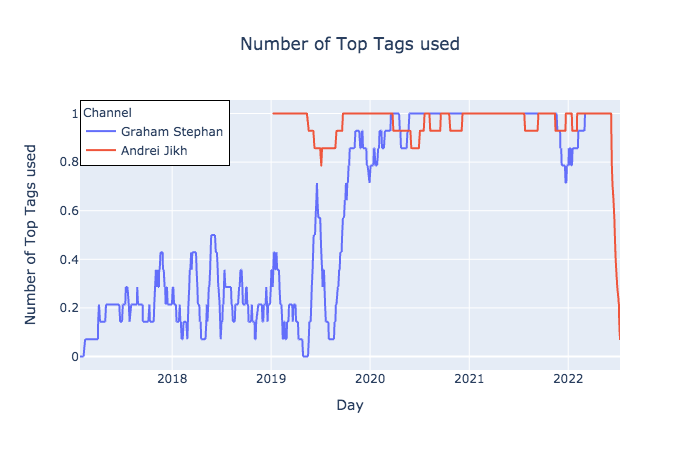

In [17]:
fig = px.line(topWords_rolling,
              x="publishedAtDay", y="topTag", color="channelTitle",
              labels={
                  "publishedAtDay": "Day",
                  "topTag": "Number of Top Tags used",
                  "channelTitle": "Channel"
              },
              title="Number of Top Tags used")
fig.update_layout(title_x=0.5, legend=dict(x = 0, y = 1, bordercolor = "Black", borderwidth = 1))
fig.show("png")

## Number of Top Title Words used

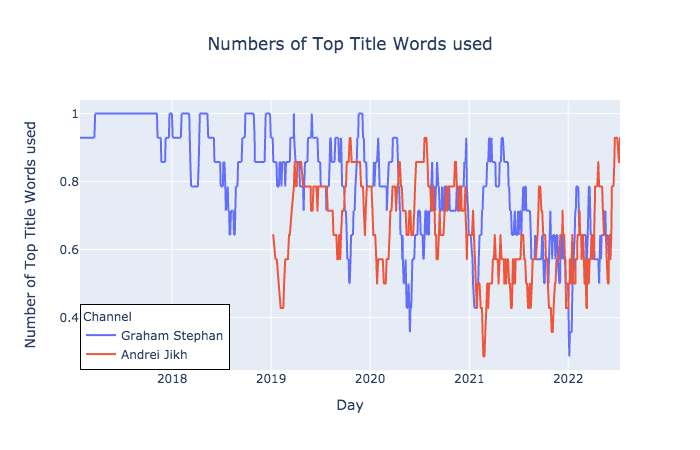

In [18]:
fig = px.line(topWords_rolling,
              x="publishedAtDay", y="topTitle", color="channelTitle",
              labels={
                  "publishedAtDay": "Day",
                  "topTitle": "Number of Top Title Words used",
                  "channelTitle": "Channel"
              },
              title="Numbers of Top Title Words used")
fig.update_layout(title_x=0.5, legend=dict(x = 0, y = 0, bordercolor = "Black", borderwidth = 1))
fig.show("png")